In [1]:
'''We start with the packages that we will need in our procedure'''

%pylab inline

import pymc3 as pm
from pymc3.backends import SQLite
import triangle
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


/home/enriques/Downloads/yes/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Initialize random number generator
np.random.seed(123)

#True parameter values
a1_real = 1.
b1_real = 1.
sigma1 = 0.3
    
#Size of dataset
size = 25

#Generating our data

def stright(a,b,size,sigma):
    x = np.random.randn(size)
    q = np.random.randn(size)*sigma
    y = a+b*x+q
    y_error = abs(q)+abs(np.random.randn(size))*0.1
    return x, y, y_error

x1, y1, y1_error = stright(a1_real,b1_real,size,sigma1)

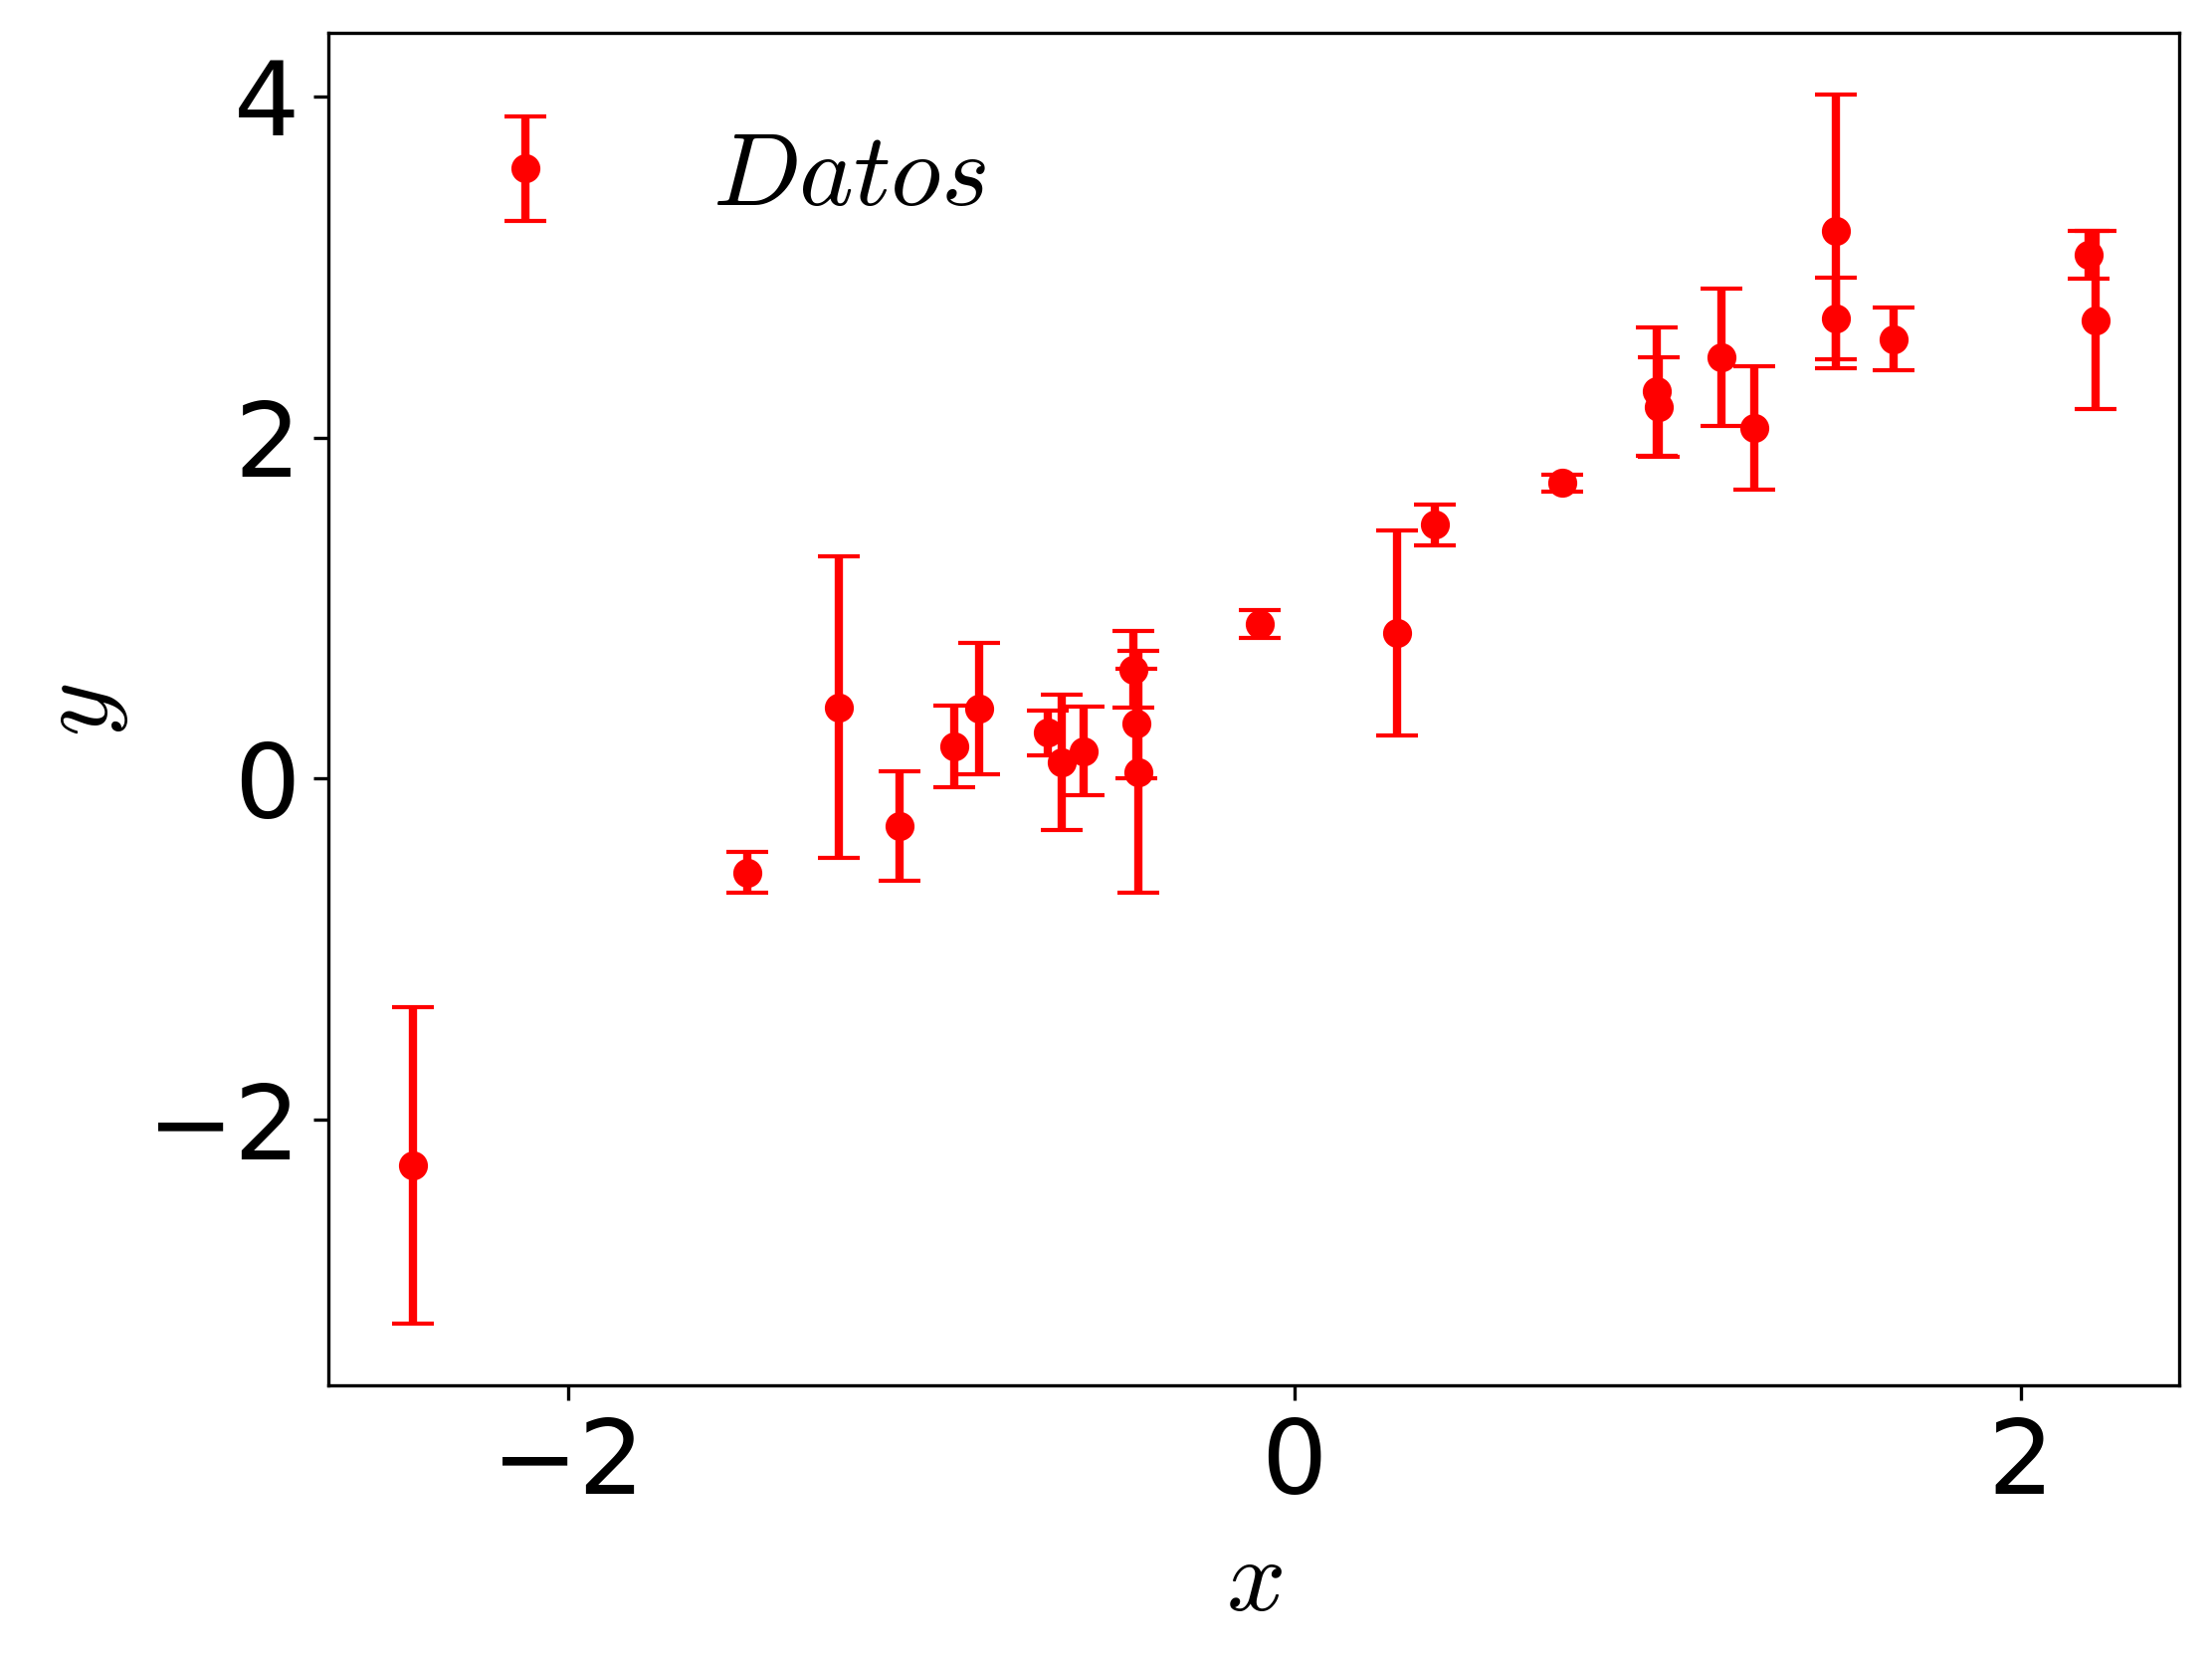

In [6]:
figsize = (8, 6)                        # definimos el tamaño de nuestra figura
dpi = 300                                # dots per inch

rcParams['font.size'] = 25           # establecemos el tamaño de la fuente
rcParams['lines.linewidth'] = 1          # el grosor de las líneas
rcParams['mathtext.fontset'] = 'cm'      # y el tipo de fuente en LaTex 

fig1 = figure(figsize=figsize, dpi=dpi)  # definimos la figura

 
plt.errorbar(x1, y1, y1_error,      #plt.errorbar(x, y, error_y)
             xerr=None, 
             color='red', marker='o', ls='None', 
             elinewidth =2, capsize=5, capthick = 1, 
             label='$Datos$')
plt.legend(loc='best', frameon=False)     #pon la legenda donde mejor quede sin marco

xlabel(r'$x$')                            
ylabel(r'$y$')  

In [24]:
# Because we are interested in an inference without taking into account hyperparameters, it results the same if we
# consider the 3 datasets as one. It can be easily to see in the gaussian approximation. In this way we star adding all
# our data in one new vector called Data_x and Data_y

Data_x = x1
Data_y = y1

with pm.Model() as model0:
    # Priors for unknown model parameters
    a0 = pm.Uniform('a', lower=-5, upper=5)
    b0 = pm.Uniform('b', lower=0, upper=4)
   # sigma0 = pm.Uniform('sigma', lower = 0, upper = 1.5)
    
    y0 = a0+b0*Data_x
    
    Lik0 = pm.Normal('Lik0',mu=y0,sd=y1_error,observed=Data_y)   

In [26]:
#We specify the number of iterations
niter0=10000
with model0:
    start0 = pm.find_MAP() #Compute a maximum a posteriori estimates 
    step0 = pm.Metropolis()
    db0 = SQLite('H01_Data.db')
    trace0 = pm.sample(niter0, trace=db0, step=step0, start=start0, njobs=6, temp = 2, thin=20, cores=4,random_seed=123)

logp = -589.3, ||grad|| = 1,676.2: 100%|██████████| 11/11 [00:00<00:00, 56.07it/s] 
Multiprocess sampling (6 chains in 6 jobs)
CompoundStep
>Metropolis: [b_interval__]
>Metropolis: [a_interval__]
  0%|          | 0/10500 [00:00<?, ?it/s]/home/enriques/Downloads/yes/lib/python2.7/site-packages/pymc3/backends/sqlite.py:121: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(self.var_dtypes[varname], np.int):
 15%|█▍        | 1572/10500 [00:01<00:09, 904.25it/s]/home/enriques/Downloads/yes/lib/python2.7/site-packages/pymc3/backends/sqlite.py:121: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(self.var_dtypes[varname], np.int):
 49%|████▉     | 5167/10500 [00:04<00:04, 1237.28it/s]/home/enriques/Dow

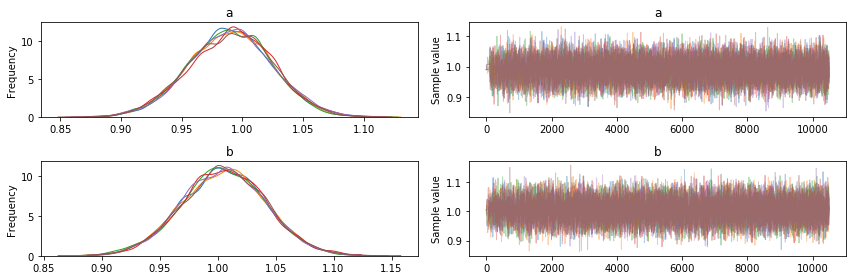

In [27]:
with model0:
    tracee = pm.backends.sqlite.load('H01_Data.db')
#    pm.traceplot(tracee, varnames=['a','b','sigma'])
    pm.traceplot(tracee, varnames=['a','b'])

In [28]:
t0 = trace0[niter0//2:]
t0['a'].shape
t0['b'].shape
#t0['sigma'].shape

(30000,)

In [29]:
a0 = trace0.get_values('a', burn=niter0//2, combine=True, chains=[0,2])
a0.shape

b0 = trace0.get_values('b', burn=niter0//2, combine=True, chains=[0,2])
b0.shape

#sigma0 = trace0.get_values('sigma', burn=niter0//2, combine=True, chains=[0,2])
#sigma0.shape

(10000,)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x122c5fd0>,
      dtype=object)

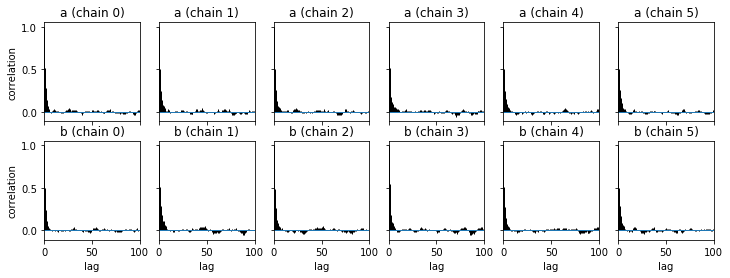

In [31]:
pm.autocorrplot(t0, varnames=['a','b'])

In [32]:
pm.effective_n(t0)

{'a': 8949.0, 'b': 9032.0}

In [33]:
pm.gelman_rubin(t0)

{'a': 1.000292504015262, 'b': 1.0002598660903768}

In [34]:
pm.summary(t0, varnames=['a','b'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,0.990577,0.034329,0.000344,0.921889,1.056034,8949.0,1.000293
b,1.004672,0.035908,0.000385,0.933702,1.075070,9032.0,1.000260


/home/enriques/Downloads/yes/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  from ipykernel import kernelapp as app
/home/enriques/Downloads/yes/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  from ipykernel import kernelapp as app


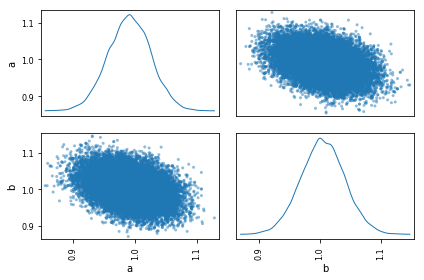

In [35]:
df_trace0 = pm.trace_to_dataframe(trace0[niter0//2:])
pd.scatter_matrix(df_trace0.ix[-niter0//2:, ['a', 'b']], diagonal='kde')
plt.tight_layout()
plt.show()

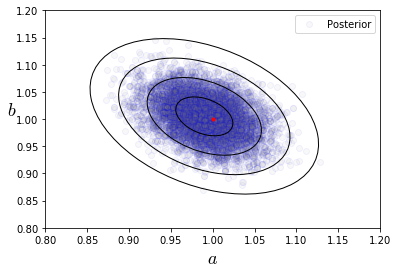

In [38]:
from matplotlib.patches import Ellipse

def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:,order]

ax = plt.subplot(111)
for nstd in range (1,5):
    cov = np.cov(a0, b0)
    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    w, h = 2 * nstd * np.sqrt(vals)
    ell = Ellipse(xy=(np.mean(a0), np.mean(b0)),
                  width=w, height=h,
                  angle=theta, color='black')
    ell.set_facecolor('none')
    ax.add_artist(ell)

plot(a0, b0,
     linestyle='none', marker='o', color='grey', mec='blue',
alpha=.05, label='Posterior', zorder=-100)

import scipy.stats
gkde = scipy.stats.gaussian_kde([a0, b0])
x,y = mgrid[0.:1.:5., 0.:100.:4.]
z = array(gkde.evaluate([x.flatten(),y.flatten()])).reshape(x.shape)
contourf(x, y, z,4, linewidths=1, alpha=.5, cmap='Greys')
plt.plot([1], [1], marker='o', markersize=3, color="red")
ylabel(r'$b$', fontsize=18, rotation=0)
xlabel(r'$a$', fontsize=18)
legend()
axis([0.8, 1.2, 0.8, 1.2])
savefig('parm_dist.png')

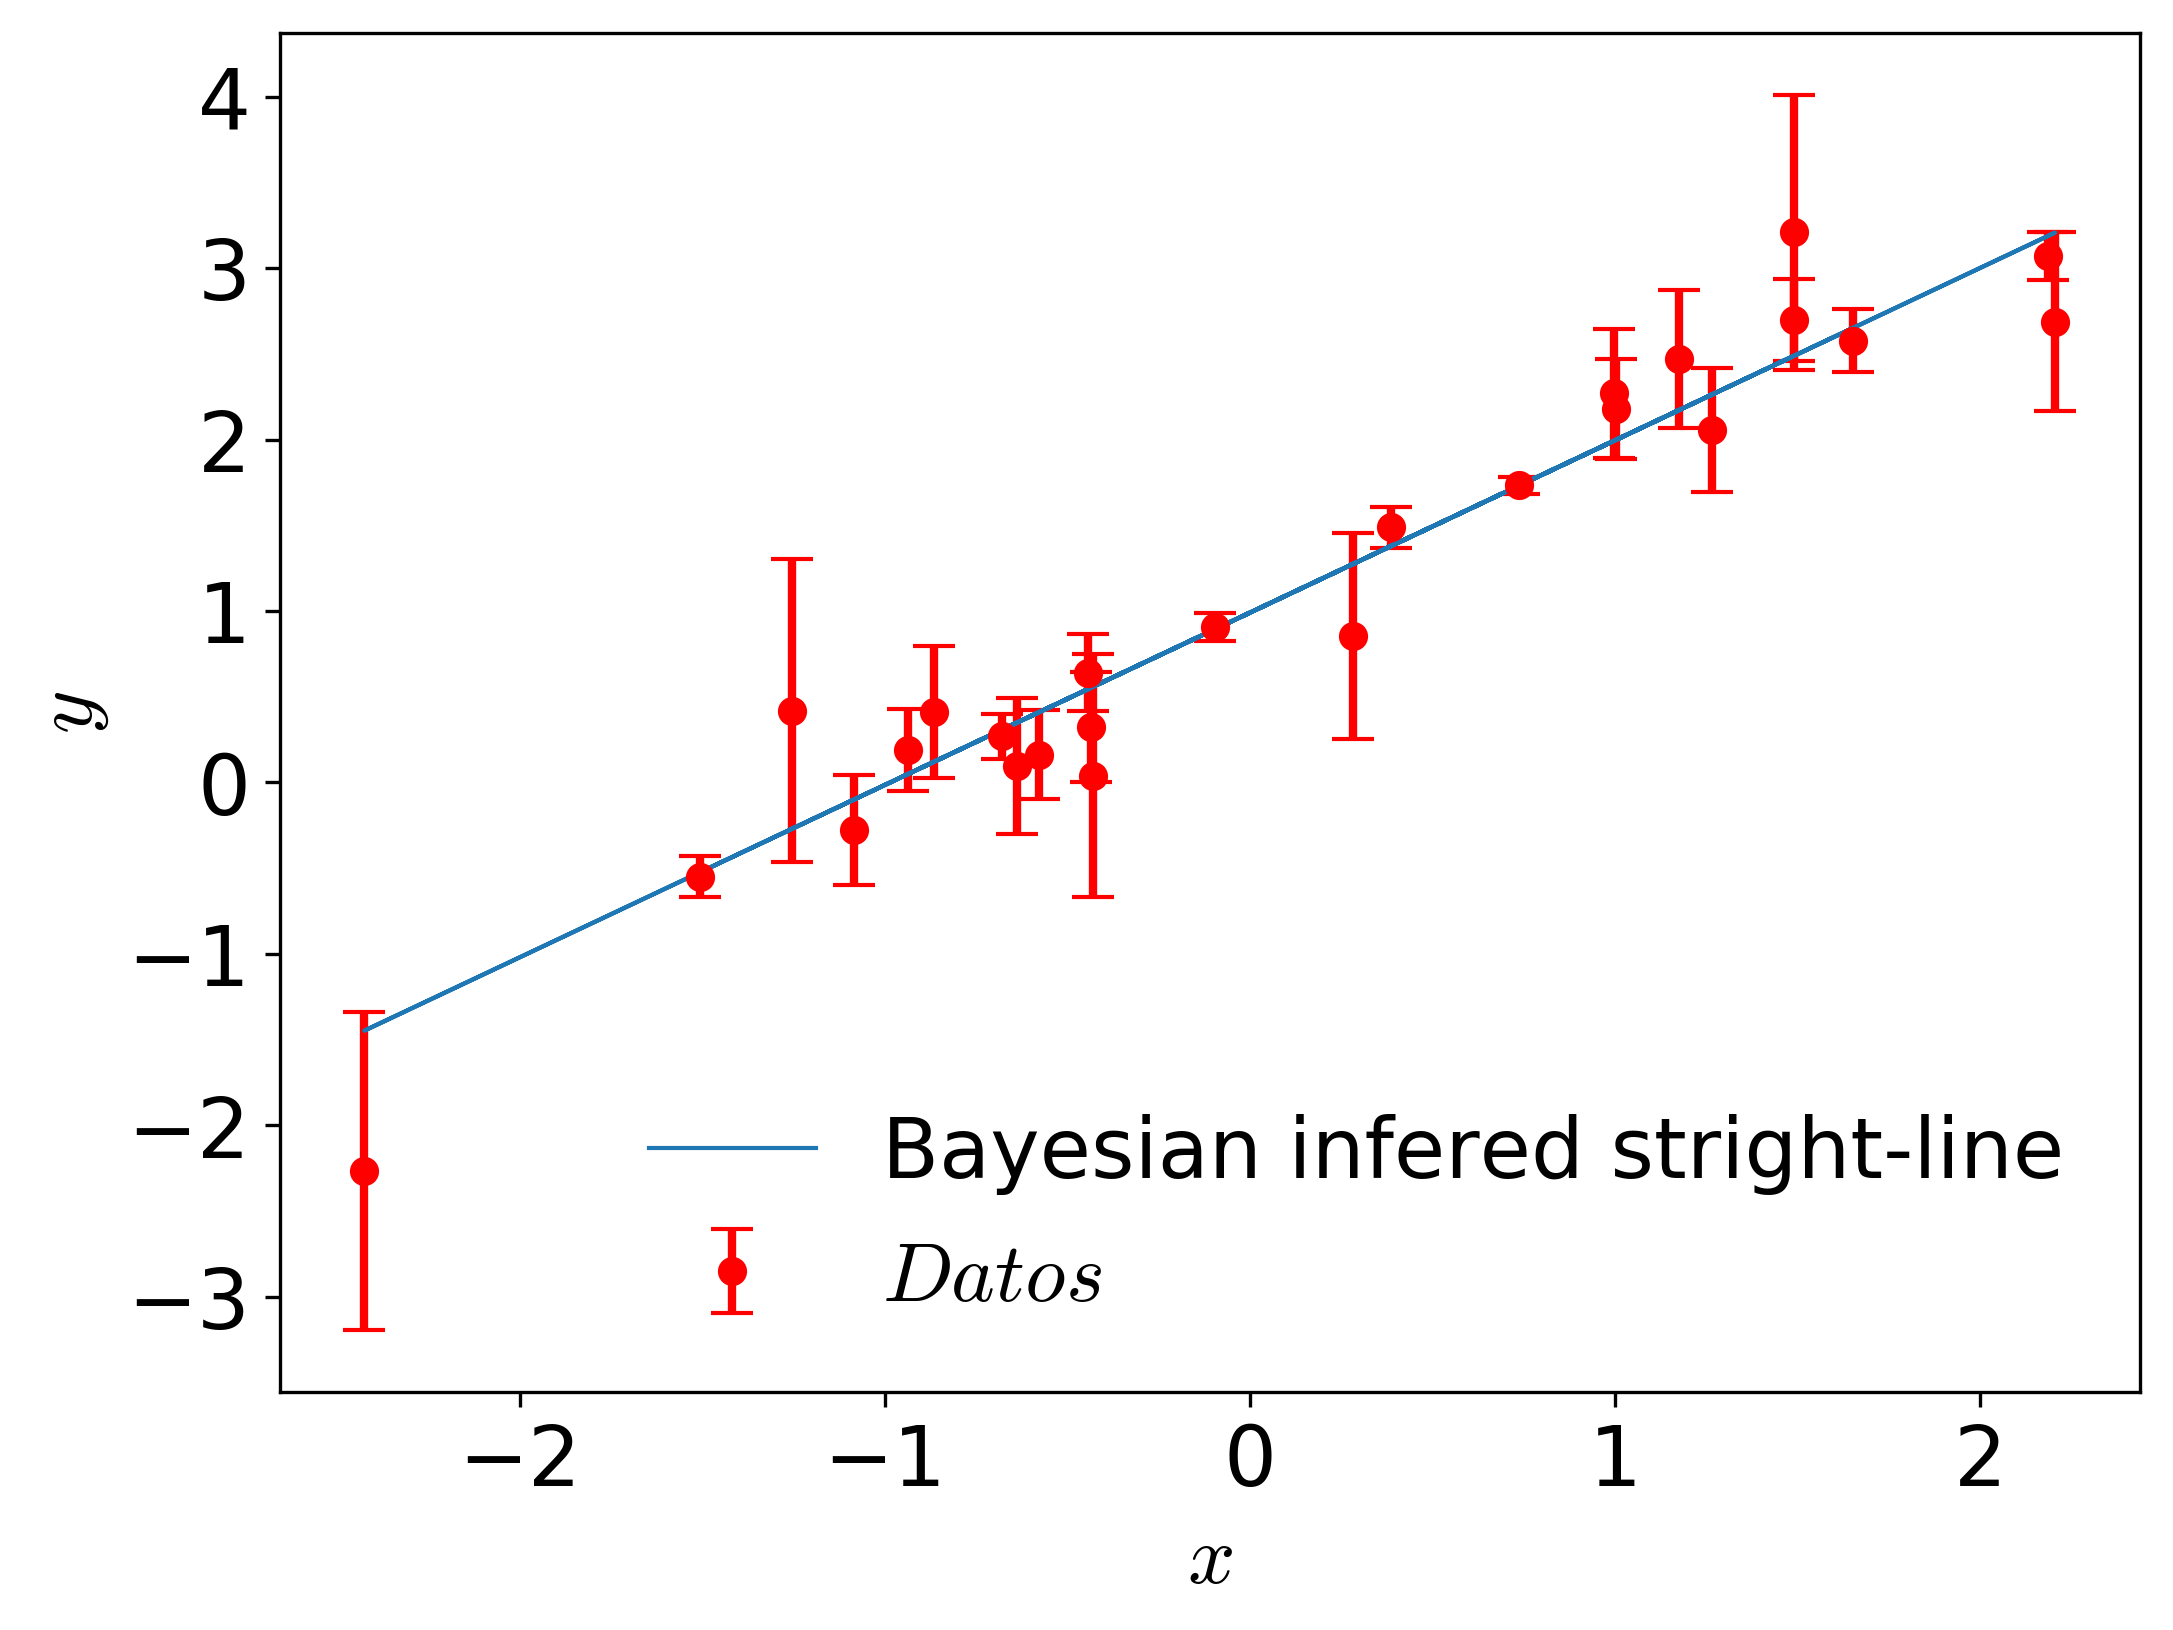

In [8]:
figsize = (8, 6)                        # definimos el tamaño de nuestra figura
dpi = 300                                # dots per inch

rcParams['font.size'] = 20          # establecemos el tamaño de la fuente
rcParams['lines.linewidth'] = 1          # el grosor de las líneas
rcParams['mathtext.fontset'] = 'cm'      # y el tipo de fuente en LaTex 

fig1 = figure(figsize=figsize, dpi=dpi)  # definimos la figura

 
plt.errorbar(x1, y1, y1_error,      #plt.errorbar(x, y, error_y)
             xerr=None, 
             color='red', marker='o', ls='None', 
             elinewidth =2, capsize=5, capthick = 1, 
             label='$Datos$')
plt.plot(x1, 0.990577+1.004672*x1, label='Bayesian infered stright-line')
plt.legend(loc='best', frameon=False)     #pon la legenda donde mejor quede sin marco

xlabel(r'$x$')                            
ylabel(r'$y$')  